# Text classification of Voice Commands
### Sections:
* [1. Load datasets](#section1)
* [2. Data analysis](#section2)
* [3. Training pipeline](#section3)
* [4. Model analysis](#section4)
* [5. Postprocessing](#section5)

Some useful imports:

In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

Fix random seed:

In [3]:
np.random.seed(1234)

# 1. Load the data <a id="section1"/>

In [4]:
data = pd.read_csv('500k.csv',sep='\t',header=None, names=['INN', 'KPP','Type','Description'])
data.drop(['INN', 'KPP'], axis=1, inplace=True)
data = pd.DataFrame({'Type': np.array(data['Type'], dtype='int'), 'Description': np.array(data['Description'])})
data = data[['Type', 'Description']]

In [5]:
print('Data size: ', data.shape)
data.head()

Data size:  (500000, 2)


,Type,Description
0,4022,Предоплата за поверку СИ по счетам N 140808 от...
1,4022,Оплата услуг по договору N40077 от 9 февраля 2...
2,4022,"Aвансовый платеж за услугибульдозеров SD32, CA..."
3,3001,Оплата за Проектные работыи предпроектные прор...
4,4018,предоплата за рекламу в газете и на сайте Ком...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
Type           500000 non-null int32
Description    498135 non-null object
dtypes: int32(1), object(1)
memory usage: 5.7+ MB


In [7]:
data.dropna(inplace=True)
print('Data size: ', data.shape)

Data size:  (498135, 2)


In [8]:
data.drop_duplicates(subset=['Type','Description'], inplace=True)
print('Data size without duplicates: ', data.shape)

Data size without duplicates:  (429426, 2)


In [9]:
X = np.array(data['Description'])
y = np.array(data['Type'], dtype = 'int')

# 2. Data analysis <a id="section2"/>

In [10]:
print('The number of classes: ', len(np.unique(y)))
unique, counts = np.unique(y, return_counts=True)
data_dict = dict(zip(unique, counts))

The number of classes:  133


In [11]:
def idx_by_count(count):
    return np.where(np.array(list(data_dict.values())) == count)[0]

def key_by_count(count):
    return np.array(list(data_dict.items()))[:,0][idx_by_count(count)]

Plot now a diagram of interclass distribution:

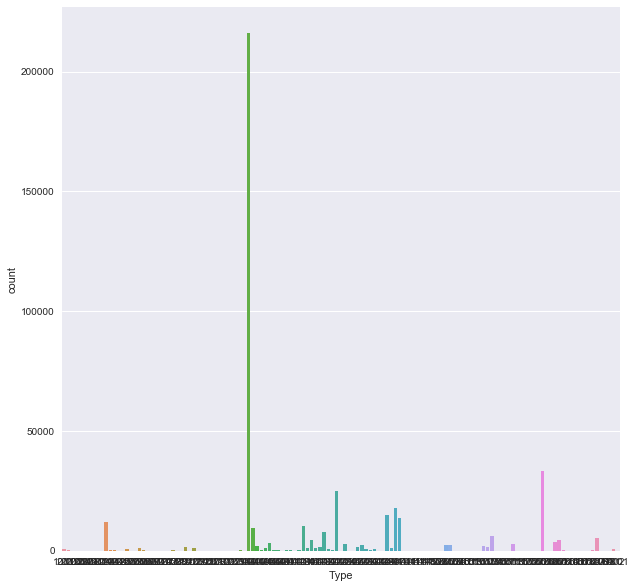

In [12]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data)

We see that we have 25% of our data belonging to one class, which means that our data is strongly unbalanced. Find this class:

In [13]:
print("Most populated class is: ", key_by_count(counts.max()))

Most populated class is:  [3001]


Delete 75% of this class instances:

In [14]:
data_cleared= data.drop(data[data.Type==3001].index[::2], inplace=False)
data_cleared = data_cleared.drop(data_cleared[data_cleared.Type==3001].index[::2], inplace=False)

In [15]:
data_3001_1 = data.drop(data[data.Type == 3001].index[1::2], inplace=False)
data_3001_2 = data_3001_1.drop(data_3001_1[data_3001_1.Type == 3001].index[1::2], inplace=False)
data_3001_1 = data_3001_1[data_3001_1.Type == 3001].copy()
data_3001_2 = data_3001_2[data_3001_2.Type == 3001].copy()
data_3001 = pd.concat([data_3001_1, data_3001_2], axis=0, join='inner')

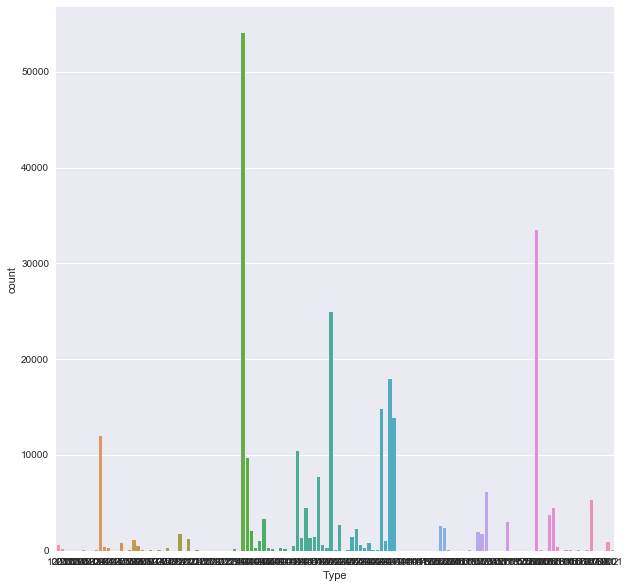

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

And we have several classes that are very rare:

In [17]:
print("Classes with only 1 sample: ", key_by_count(1))

Classes with only 1 sample:  [2011 2047 2074 2084 2120 2129 4105 4117 5010 5125 6218]


In [18]:
print("Classes with only 2 sample: ", key_by_count(2))

Classes with only 2 sample:  [2002 2005 2110 2127 4110 5105]


Delete the entries in data with the total number of a class less than 10:

In [19]:
def delete_minor_classes(data, min_count = 10):
    data_copy = data.copy()
    for i in range(1, min_count + 1):
        classes = key_by_count(i)
        for class_name in classes:
            data_copy.drop(data_copy[data_copy.Type==class_name].index, inplace=True)
    return data_copy

In [20]:
data_cleared = delete_minor_classes(data_cleared, 10)

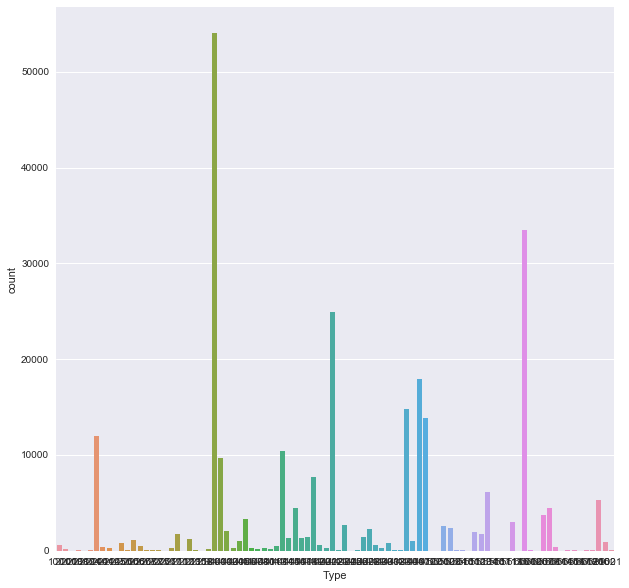

In [21]:
plt.figure(figsize=(10,10))
sns.countplot(x="Type", data=data_cleared)

# 3. Preprocessing and training pipeline <a id="section3"/>

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from utils import stemming

In [25]:
from nltk.corpus import stopwords
stopwordlist = stopwords.words('russian')

## 3.1 Straight-forward Classification <a id="section3.1"/>

# <font color='red'>TODO: ???</font>

## 3.2 Classification using cleared data <a id="section3.2"/>

 As we have seen, our data is highly unbalanced, thus we can try to use cleared data, where the most populated class is reduced.

Split the data into train and test sets:

In [26]:
test_size = 0.2
X = np.array(data_cleared['Description'])
y = np.array(data_cleared['Type'], dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [28]:
parameters = {'vect__ngram_range': [(1,1), (1, 2)],
              'vect__min_df': (3, 4),
              'vect_max_df': (0.8, 0.9, 0.95),
              'tfidf__use_idf': [True],
              'clf__alpha': (1e-6,1e-7),
              'clf__max_iter': [50],
              'clf__penalty': ['l2']
}

text_clf = Pipeline([('vect', CountVectorizer(analyzer=stemming)),
                     ('tfidf', TfidfTransformer(norm='l1')),
                     ('clf', SGDClassifier(loss='log',
                                           random_state=1234,
                                           n_jobs=-1))
])

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=-1, verbose=5)

C:\Users\Yaroslav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Train a classifier:

In [26]:
gs_clf.fit(X_train, y_train)
best_clf = gs_clf.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 106.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 614.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 699.5min finished


In [27]:
gs_clf.best_params_

{'clf__alpha': 1e-06,
 'clf__max_iter': 50,
 'clf__penalty': 'l1',
 'tfidf__use_idf': True,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 1)}

on 100% of data

In [28]:
gs_clf.best_score_

0.90697652656844352

on 10% of data

In [40]:
gs_clf.best_score_

0.8960927025474047

Compute the accuracy:

on 100% of data

In [30]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

Accuracy on the train:  0.915622909171
Accuracy on the test:  0.907304474763


on 10% of data

In [41]:
print('Accuracy on the train: ', accuracy_score(y_train, best_clf.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, best_clf.predict(X_test)))

Accuracy on the train:  0.906488220647
Accuracy on the test:  0.901685500862


In [31]:
best_clf.predict_proba(['сталин это что']).max()

0.75373150806132916

In [32]:
best_clf.predict_proba(['Какой то абсолютный бред бред бреееееееееееед']).max()

0.30847741059966866

## 3.3 Classification without GridSearch <a id="section3.3"/>

Use stopwords, higher min_df and low max_df:

In [201]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=stemming, stop_words=stopwordlist, min_df = 10, max_df = 0.8, ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer(norm='l1', use_idf=True)),
                     ('clf', SGDClassifier(loss='log', alpha=1e-7, max_iter=50,
                                           random_state=1234, penalty='l2',
                                           n_jobs=-1))
])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemming at 0x00000244980E7840>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.8,
        max_features=None, min_df=10, ngram_range=(1, 2),
        prepr...='l2', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [202]:
print('Accuracy on the train: ', accuracy_score(y_train, pipe.predict(X_train)))
print('Accuracy on the test: ', accuracy_score(y_test, pipe.predict(X_test)))

Accuracy on the train:  0.929846395703
Accuracy on the test:  0.909119832313


In [214]:
best_clf = pipe
accuracy, X_test_, y_test_, y_pred_, examples_for_manual_clf = classify(X_test, y_test, y_train)

In [215]:
accuracy

0.93653519680998065

In [30]:
pipe = load('pipe_0.91.pkl')

In [31]:
y_pred = pipe.predict(X_test)

# 4. Model Analysis <a id="section4"/>

Some useful function:

In [61]:
def class_by_idx(y, index):
    unique, counts = np.unique(y, return_counts=True)
    data_dict = dict(zip(unique, counts))
    return np.array(list(data_dict.keys()))[index]

def find_most_probable_class(y, probabilities, n_classes=2):
    probabilities = probabilities[0]
    sorted_prob = np.sort(probabilities)
    idx_sorted_prob = probabilities.argsort()
    return class_by_idx(y, idx_sorted_prob[-n_classes:][::-1]), sorted_prob[-n_classes:][::-1]

First of all, loot at the confusion matrix:

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
def pretty_print_of_confusion_matrix(C, classes):
    n = C.shape[0]
    flag = 0
    for row in range(n):
        for column in range(n):
            #if row==column:
            if flag == 0:
                print(">> Class %d true: \t\t [%d]" % (classes[row], C[row, row]) )
            else:
                if C[row, column] + C[column, row] != 0 and column != row:
                    print(">> Classes (%d vs. %d): \t [%d] and [%d]" % 
                          (classes[row], classes[column], C[row, column], C[column,row]))
            flag += 1
            if flag == n:
                flag = 0

In [64]:
classes = pipe.classes_
C = confusion_matrix(y_test, y_pred,labels=classes)

In [65]:
def max_c(C, classes):
    cij_max = 0
    ci_max = 0
    for i in range(C.shape[0]):
        ci_max = 0
        for j in range(C.shape[0]):
            if C[i,j] + C[j,i] > cij_max and i != j:
                cij_max = C[i,j] + C[j,i]
                idx = (i,j)
    return classes[idx[0]], classes[idx[1]], cij_max

In [66]:
max_c(C, classes)

(4060, 5104, 535)

In [67]:
unique, counts = np.unique(y_train, return_counts=True)
data_dict = dict(zip(unique, counts))
pretty_print_of_confusion_matrix(C, classes)

>> Class 1001 true: 		 [98]
>> Classes (1001 vs. 2008): 	 [1] and [3]
>> Classes (1001 vs. 2041): 	 [0] and [1]
>> Classes (1001 vs. 3001): 	 [6] and [0]
>> Classes (1001 vs. 4006): 	 [0] and [1]
>> Classes (1001 vs. 4022): 	 [7] and [0]
>> Classes (1001 vs. 4040): 	 [1] and [0]
>> Classes (1001 vs. 4070): 	 [1] and [0]
>> Class 2001 true: 		 [26]
>> Classes (2001 vs. 3001): 	 [1] and [0]
>> Classes (2001 vs. 4001): 	 [5] and [0]
>> Classes (2001 vs. 4005): 	 [1] and [0]
>> Classes (2001 vs. 4022): 	 [1] and [0]
>> Classes (2001 vs. 4040): 	 [1] and [0]
>> Class 2003 true: 		 [0]
>> Class 2008 true: 		 [13]
>> Classes (2008 vs. 2024): 	 [0] and [1]
>> Classes (2008 vs. 2050): 	 [1] and [0]
>> Classes (2008 vs. 3001): 	 [4] and [0]
>> Classes (2008 vs. 4001): 	 [1] and [0]
>> Classes (2008 vs. 4022): 	 [2] and [0]
>> Classes (2008 vs. 4024): 	 [1] and [0]
>> Class 2010 true: 		 [2]
>> Class 2024 true: 		 [9]
>> Classes (2024 vs. 2008): 	 [1] and [0]
>> Classes (2024 vs. 3001): 	 [1] and

In [70]:
C_ = C
for i in range(C_.shape[0]):
    C_[i,i] = 150

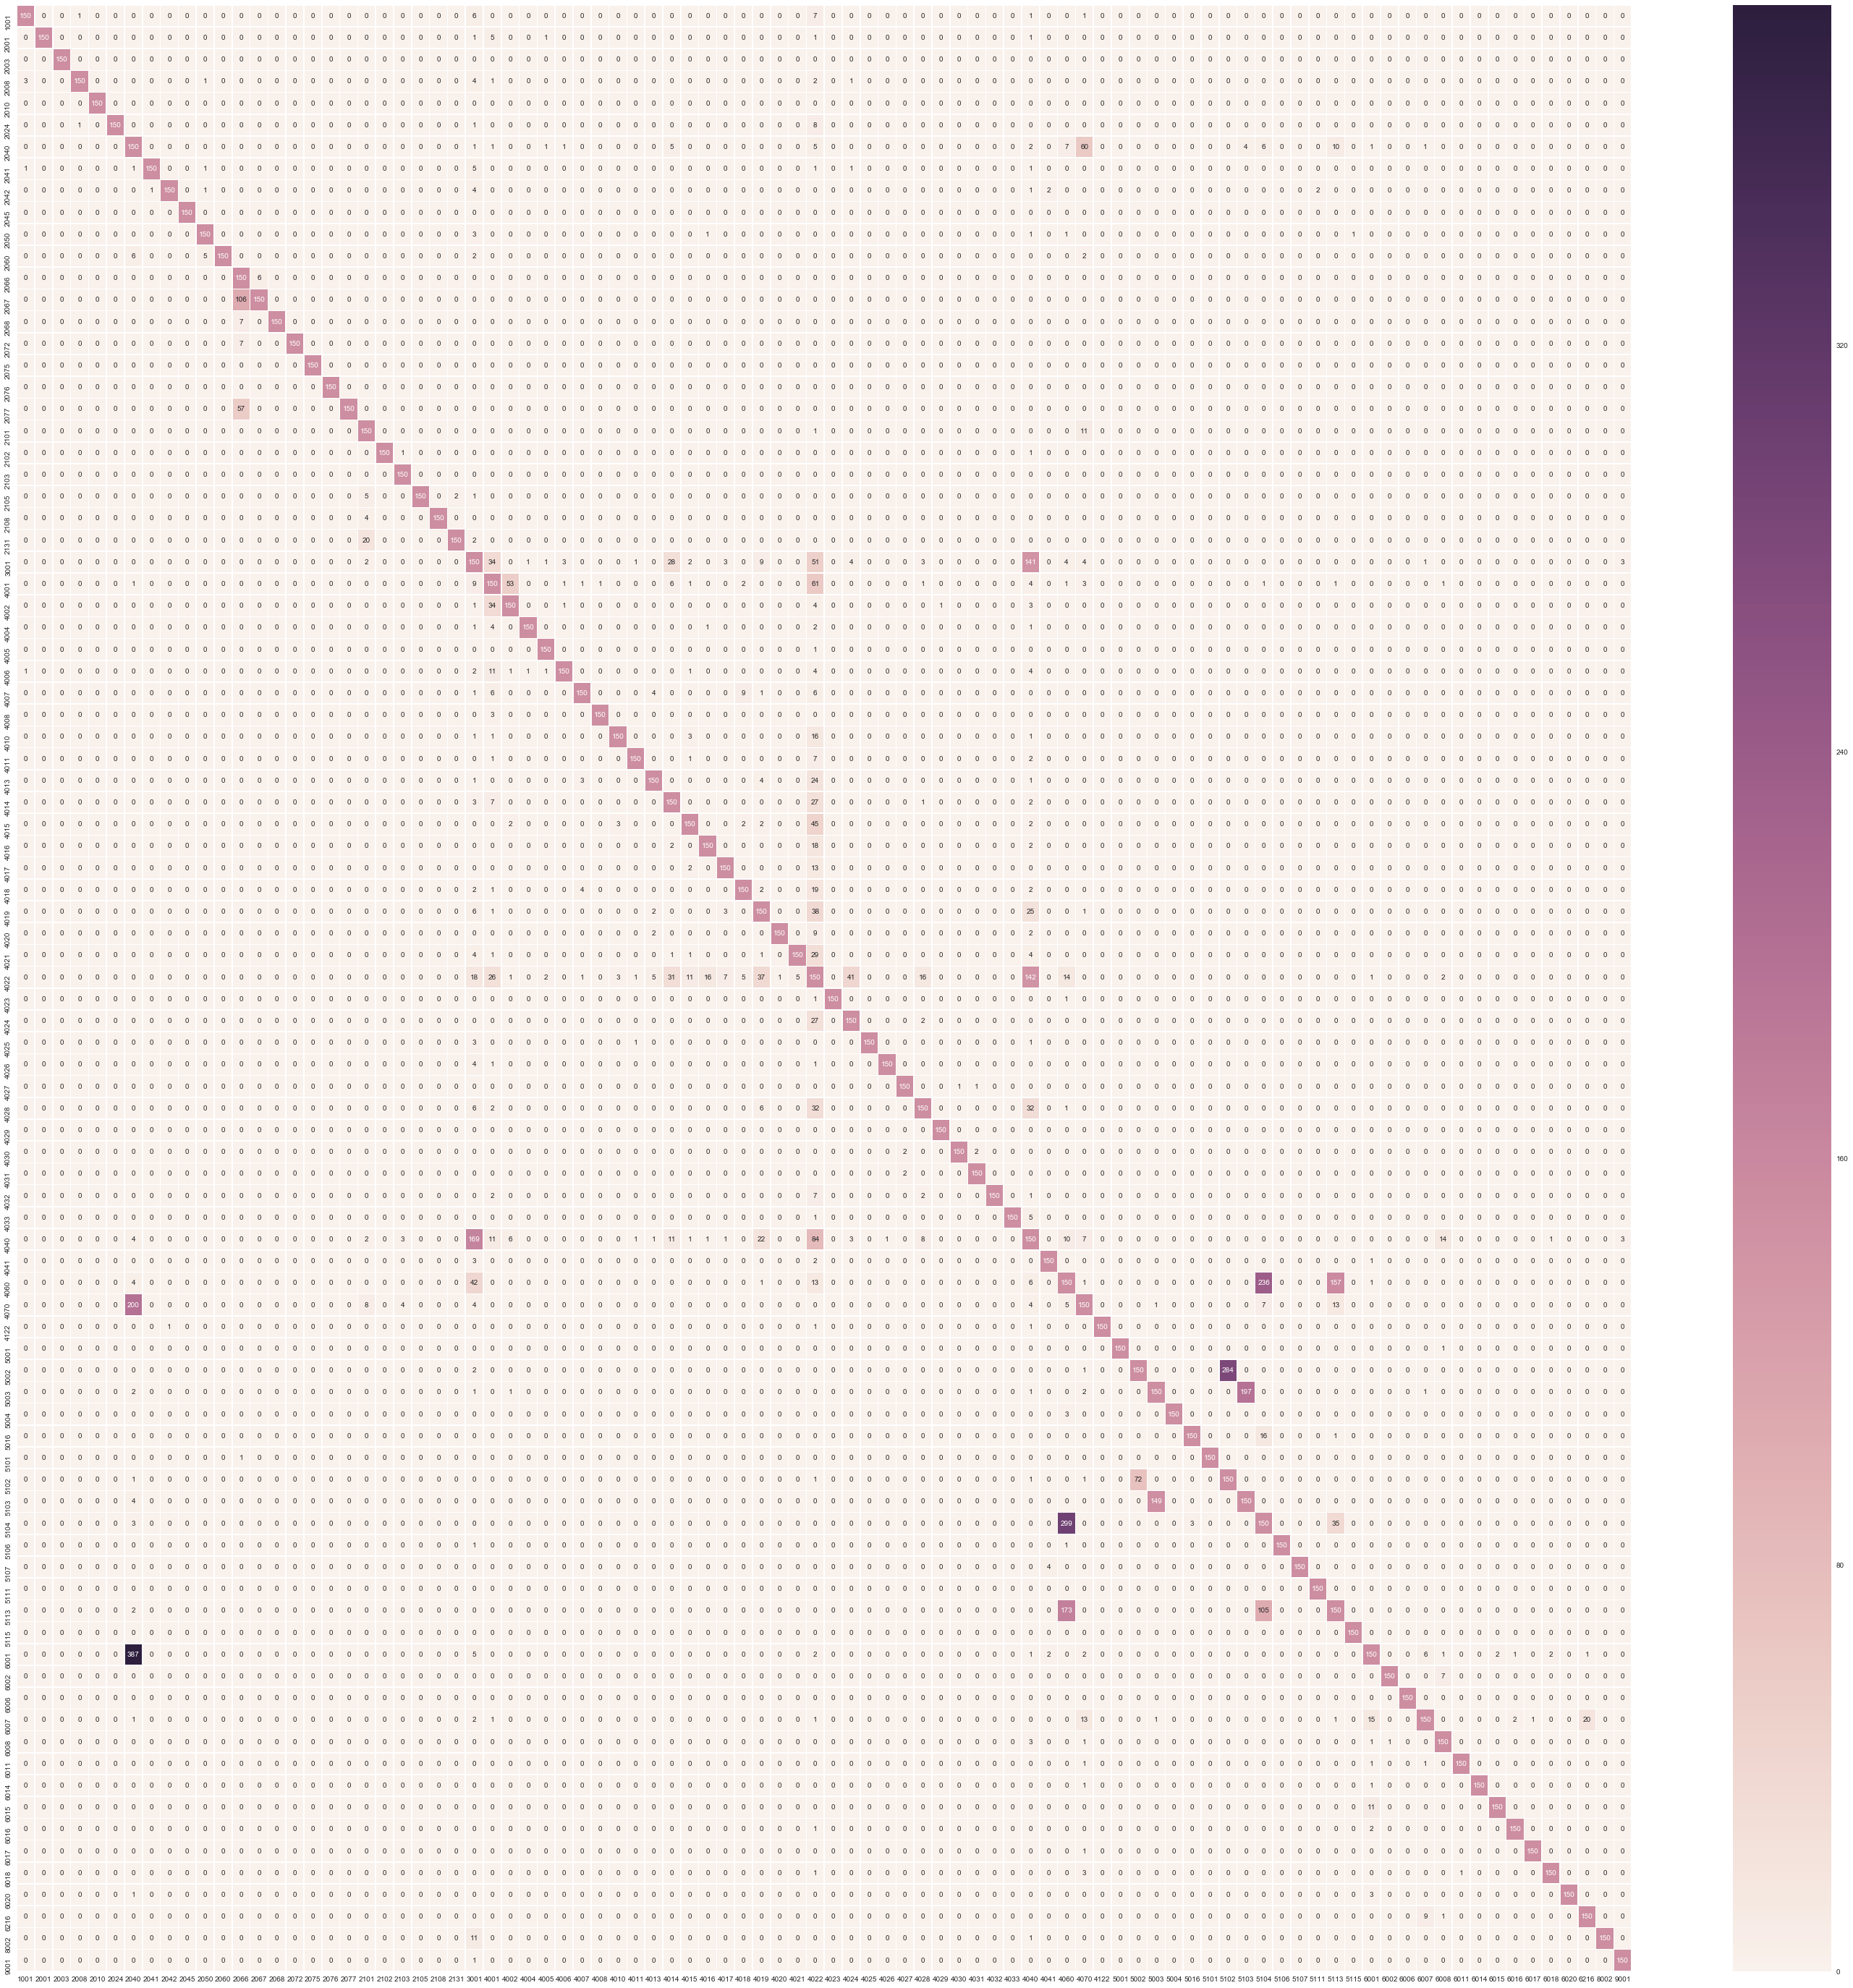

In [71]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(C_, annot=True, fmt="d", linewidths=.5, ax=ax, xticklabels=classes, yticklabels=classes)
sns.plt.savefig('heatmap.png')

## <font color="Blue">Consider several difficult cases:</font>

After exploring the heatmap, we see that there are two different cases: a peak error for 2 classes and a long tail of error for a certain class.

## 4.1 Picked error <a id="section4.1"/>

### 4.1.1 Example #1

Take the highest error from the heatmap, we see that this error belongs to classification of **6001** and **2040** classes. Take a look at them:

In [90]:
data[data.Type == 6001].tail(2)

,Type,Description
474214,6001,"Комиссия (0,1% за зачисление по договору N1642..."
479203,6001,Комиссия за исх. платеж через ЦБ РФ на основан...


In [89]:
data[data.Type == 2040].tail(2)

,Type,Description
499559,2040,Выплата процентов (18.50%)с 18/12/2014 по 23/1...
499593,2040,Выплата процентов (11.25%)с 18/05/2015 по 19/0...
499599,2040,Выплата процентов (11.25%)с 15/06/2015 по 16/0...
499602,2040,Выплата процентов (11.00%)с 18/06/2015 по 23/0...
499637,2040,Выплата процентов (10.3%) с 03/11/2015 по 05/1...


In [88]:
X_test[(y_test == 6001) & (y_pred == 2040)]

array(['№REF35721<<ИМЯ>ИНН=КПП=', '№REF19303<<ИМЯ>ИНН=КПП=',
       '№REF52330<<ИМЯ>ИНН=КПП=', '№REF33873<<ИМЯ>ИНН=КПП=',
       '№REF59927<<ИМЯ>ИНН=КПП=', '№REF52349<<ИМЯ>ИНН=КПП=',
       '№REF48369<<ИМЯ>ИНН=КПП=', '№REF13912<<ИМЯ>ИНН=КПП=',
       '№REF70491<<ИМЯ>ИНН=КПП=', '№REF33068<<ИМЯ>ИНН=КПП=',
       '№REF13883<<ИМЯ>ИНН=КПП=', '№REF65906<<ИМЯ>ИНН=КПП=',
       '№REF41098<<ИМЯ>ИНН=КПП=', '№REF13418<<ИМЯ>ИНН=КПП=',
       '№REF33860<<ИМЯ>ИНН=КПП=', '№REF70754<<ИМЯ>ИНН=КПП=',
       '№REF8733<<ИМЯ>ИНН=КПП=', '№REF37375<<ИМЯ>ИНН=КПП=',
       '№REF34874<<ИМЯ>ИНН=КПП=', '№REF65935<<ИМЯ>ИНН=КПП=',
       '№REF33835<<ИМЯ>ИНН=КПП=', '№REF36656<<ИМЯ>ИНН=КПП=',
       '№REF835<<ИМЯ>ИНН=КПП=', '№REF67257<<ИМЯ>ИНН=КПП=',
       '№REF11626<<ИМЯ>ИНН=КПП=', '№REF71329<<ИМЯ>ИНН=КПП=',
       '№REF8721<<ИМЯ>ИНН=КПП=', '№REF73563<<ИМЯ>ИНН=КПП=',
       '№REF48340<<ИМЯ>ИНН=КПП=', '№REF2359<<ИМЯ>ИНН=КПП=',
       '№REF26086<<ИМЯ>ИНН=КПП=', '№REF76080<<ИМЯ>ИНН=КПП=',
       '№REF68437<<ИМЯ>ИНН=КП

### 4.1.2 Example #2

Take another high error from the heatmap that belongs to classification of **4070** and **2040** classes. Take a look at them:

In [94]:
data[data.Type == 4070].tail(2)

,Type,Description
496571,4070,Частичное погашение займа по договору беспроце...
497622,4070,Частичное погашение займа по договору беспроце...


In [89]:
data[data.Type == 2040].tail(2)

,Type,Description
499559,2040,Выплата процентов (18.50%)с 18/12/2014 по 23/1...
499593,2040,Выплата процентов (11.25%)с 18/05/2015 по 19/0...
499599,2040,Выплата процентов (11.25%)с 15/06/2015 по 16/0...
499602,2040,Выплата процентов (11.00%)с 18/06/2015 по 23/0...
499637,2040,Выплата процентов (10.3%) с 03/11/2015 по 05/1...


In [95]:
X_test[(y_test == 4070) & (y_pred == 2040)]

array(['№REFD269301<<ИМЯ>ИНН=КПП=', '№REFD434557<<ИМЯ>ИНН=КПП=',
       '№REFD398502<<ИМЯ>ИНН=КПП=', '№REFD781881<<ИМЯ>ИНН=КПП=',
       '№REFD368927<<ИМЯ>ИНН=КПП=', '№REFD429738<<ИМЯ>ИНН=КПП=',
       '№REFD018977<<ИМЯ>ИНН=КПП=',
       '1708878.608470.665002№REFAMphD0220322<<ИМЯ>ИНН=КПП=',
       '№REFD072031<<ИМЯ>ИНН=КПП=', '№REFD240058<<ИМЯ>ИНН=КПП=',
       '№REFD790714<<ИМЯ>ИНН=КПП=', '№REFD065685<<ИМЯ>ИНН=КПП=',
       '№REFD092180<<ИМЯ>ИНН=КПП=', '№REFD063407<<ИМЯ>ИНН=КПП=',
       '№REFD752616<<ИМЯ>ИНН=КПП=', '№REFD296531<<ИМЯ>ИНН=КПП=',
       '№REFD319398<<ИМЯ>ИНН=КПП=',
       'Покупка/продажа валюты по заявке № 1(1).№REF1<<ИМЯ>ИНН=3128011788',
       '№REFD467258<<ИМЯ>ИНН=КПП=', '№REFD315949<<ИМЯ>ИНН=КПП=',
       '[КП] платеж по договору займа, НДС не облагается НДС не облагается№REF23<<ИМЯ>ИНН=4823006703КПП=997550001',
       '№REFD791878<<ИМЯ>ИНН=КПП=', '№REFD112616<<ИМЯ>ИНН=КПП=',
       'XX.1711652.617382.665002№REFAMphI0270198<<ИМЯ>ИНН=КПП=',
       '№REFD746808<<ИМЯ

### 4.1.3 Example #3

Take another high error from the heatmap that belongs to classification of **5104** and **4060** classes. Take a look at them:

In [115]:
data[data.Type == 4060].iloc[5:10]

,Type,Description
31414,4060,{VO01010} Операция по продаже валюты по заявле...
31415,4060,{VO01010} Операция по продаже валюты по заявле...
31416,4060,{VO01010} Операция по продаже валюты по заявле...
31417,4060,{VO01010} Операция по продаже валюты по заявле...
31418,4060,{VO01010} Операция по продаже валюты по заявле...


In [103]:
data[data.Type == 5104].tail(5)

,Type,Description
489295,5104,Продажа валюты по курсу Банка. Курс: 59.9100№R...
489455,5104,Конверсионная сделка Spot № 933972 продажа USD...
497046,5104,Покупка/продажа валюты по заявке № 94(94).№REF...
497047,5104,Покупка/продажа валюты по заявке № 93(93).№REF...
497368,5104,Покупка/продажа валюты по заявке № 368(368).№R...


In [100]:
X_test[(y_test == 5104) & (y_pred == 4060)]

array([ 'Покупка/продажа валюты по заявке № 140(140).№REF140<<ИМЯ>НЛМК ОАОИНН=4823006703',
       '{VO01010} Операция по продаже валюты по заявлению №0000402 от 21.06.2016. Курс 64.06500№REF123909<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНКИНН=7730060164КПП=',
       '{VO01010} Операция по продаже валюты по заявлению №0000807 от 01.11.2016. Курс 63.16500№REF135945<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНКИНН=7730060164КПП=',
       'Продажа валютных средств, поручение на продажу валютных средств по ПП 5 от 13/03/2015№REF<<ИМЯ>ИНН=2205001753КПП=',
       'Покупка/продажа валюты по заявке № 597(597).№REF<<ИМЯ>ИНН=4823006703',
       'Покупка/продажа валюты по заявке № 16(16).№REF16<<ИМЯ>НЛМК ОАОИНН=4823006703',
       'Покупка/продажа валюты по заявке № 156(156).№REF156<<ИМЯ>НЛМК ОАОИНН=4823006703',
       '{VO01010} Операция по продаже валюты по заявлению №0000167 от 11.07.2016. Курс 64.17250№REF39757<<ИМЯ>УРАЛЬСКИЙ ФИЛИАЛ ПАО РОСБАНКИНН=7730060164КПП=',
       'Продажа валюты по курсу Банка. Курс: 38.

In [107]:
entry = 'Покупка/продажа валюты по заявке № 806(806).№REF<<ИМЯ>ИНН=4823006703'
find_most_probable_class(y_train, pipe.predict_proba([entry]))

(array([4060, 5104]), array([ 0.88766283,  0.06318255]))

We see that our classifier confuses **5103** and **5003** classes, and in our data we have several entries, which belong to that classes:

In [370]:
entry = '{VO61100} Зачисление валютной выручки согласно поруч.N 107 от 11/11/2010г. ОАО  НЛМК  Уведомление N 71873 от 10/11/2010г.<<ИМЯ>ОАО  НЛМКИНН=4823006703КПП=0'

In [371]:
data[data.Description==entry]

,Type,Description
278875,5003,{VO61100} Зачисление валютной выручки согласно...
278878,5103,{VO61100} Зачисление валютной выручки согласно...


In [372]:
probs = best_clf.predict_proba([entry])
find_most_probable_class(y_train, probs, 2)

(array([5103, 5003]), array([ 0.49555008,  0.4785053 ]))

## 4.2 Next step <a id="section4.2"/>

In [41]:
mistakes = np.array([i for i in range(len(y_pred_)) if (y_pred_[i] != y_test_[i])])

In [42]:
entry = 'Покупка/продажа валюты по заявке № 27(27).№REF27<<ИМЯ>НЛМК ОАОИНН=4823006703'

In [43]:
data[data.Description == 'Покупка/продажа валюты по заявке № 27(27).№REF27<<ИМЯ>НЛМК ОАОИНН=4823006703']

,Type,Description
34314,4060,Покупка/продажа валюты по заявке № 27(27).№REF...
480248,5104,Покупка/продажа валюты по заявке № 27(27).№REF...


In [70]:
find_most_probable_class(y_train,best_clf.predict_proba([entry]),2)

(array([4028, 3001]), array([ 0.35762322,  0.27690191]))

In [72]:
mistakes

array([   18,    23,    29, ..., 51039, 51045, 51047])

In [74]:
j = 18
X_test_[j], y_pred_[j], y_test_[j]

('Покупка/продажа валюты по заявке № 140(140).№REF140<<ИМЯ>НЛМК ОАОИНН=4823006703',
 4060,
 5104)

In [75]:
pr = best_clf.predict_proba([X_test_[j]])

In [76]:
find_most_probable_class(y_train, pr, 2)

(array([4060, 5113]), array([ 0.45005059,  0.29812294]))

In [77]:
countvector = best_clf.named_steps['vect']
tfid = best_clf.named_steps['tfidf']

In [78]:
ar = tfid.transform(countvector.transform(['Зарплата сотрудников по ведомости N221 от 28.09.2012 НДС не облагается№REF61618<<ИМЯ>ИНН=6608003052КПП=667101001']))

## 4.3 Strange description <a id="section4.3"/>

The first thing to consider is that classes **2101** and **2103** are pretty similar:

And our classifier works fine:

In [80]:
def lazy_print(idx):
    print('%r => %s, true: %s' % (X_test[idx], best_clf.predict([X_test[idx]]),y_test[idx]))

In [81]:
data[data.Type == 5113].Description[426189]

'CHRG:BEN№REFFX00439344-02-01<<ИМЯ>'

In [86]:
mistakes

array([   18,    23,    29, ..., 51039, 51045, 51047])

In [88]:
lazy_print(23)

'Оплата за аренду нежилого помещения за март, апрель, май месяцы 2017г. Оплата подоговору № 126700 от 01.09.2014г. Сумма 10673-00 В том числе НДС: 1628-10№REF5<<ИМЯ>Общество с ограниченной ответственностью  ТЕХПРОМЭНЕРГОИНН=6658114167' => [4022], true: 2024


In [52]:
find_most_probable_class(y_train[::10], best_clf.predict_proba([X_test[14]]), n_classes=3)

(array([4022, 3001, 4070]), array([ 0.80748896,  0.05991611,  0.04561528]))

In [53]:
y_test[14]

4022

In [54]:
mistakes.shape

(3695,)

## 4.4 Other mistakes <a id="section4.4"/>

In [55]:
mistakes

array([   18,    23,    29, ..., 51039, 51045, 51047])

In [56]:
mistakes.shape
mistakes[2040:2060]

array([28229, 28236, 28237, 28255, 28268, 28269, 28278, 28317, 28330,
       28356, 28388, 28389, 28399, 28427, 28453, 28454, 28456, 28459,
       28467, 28488])

In [57]:
j = 21329
X_test_[j], y_pred_[j], y_test_[j]

('Оплата за пост управления по дог. 506/12Д, спец. 7, сч. 1 408 989 от 04.10.2012 В т.ч. НДС 18%- 257-36<<ИМЯ>Общество с ограниченной ответственностью РС ЛогистикаИНН=7704524684КПП=771601001',
 4001,
 4001)

In [58]:
pr = best_clf.predict_proba([X_test_[j]])

In [59]:
find_most_probable_class(y_train, pr, 2)

(array([4001, 4022]), array([ 0.56621036,  0.19014649]))

In [143]:
entry = 'Списание долларов США для продажи согласно заявки №67от 01.03.2012г.№REF40740894<<ИМЯ>ИНН=7729405872'
data_cleared[data_cleared.Description == entry]

,Type,Description
132448,5004,Списание долларов США для продажи согласно зая...


In [152]:
probs = best_clf.predict_proba([entry])

In [153]:
find_most_probable_class(y_train, probs, 2)

(array([4060, 5004]), array([ 0.54328869,  0.40173498]))

In [154]:
entry = 'Арендная плата за октябрь 2013г. по ДАЗУ 33 от 13.12.2005 НДС не облагается<<ИМЯ>УФК по Свердловской области (МУГИСО)ИНН=6658091960КПП=667001001'
data_cleared[data_cleared.Description == entry]

,Type,Description
450747,4028,Арендная плата за октябрь 2013г. по ДАЗУ 33 от...


## 4.5  Hold-out 75% of 3001 class <a id="section4.5"/>

In [155]:
y_3001 = best_clf.predict(data_3001.Description[::20])
print('Accuracy for 3001:', accuracy_score(y_3001, 3001*np.ones(len(y_3001))))

Accuracy for 3001: 0.970392301999


# 5. Postprocessing <a id="section5"/>

Now, find difficult cases: where the clf gives almost equal probability for 2 classes. Consider these examples separately. 

In [37]:
def classify(X_test, y_test, y_train, eps = 0.1):
    examples_for_manual_clf = []
    X_test_ = []
    y_test_ = []
    y_pred_ = []
    for entry_test, i in zip(X_test, range(len(X_test))):
        probs = best_clf.predict_proba([entry_test])
        top_2_classes, top_2_probs = find_most_probable_class(y_train, probs, 2)
        if np.abs(top_2_probs[0] - top_2_probs[1]) < eps:
            examples_for_manual_clf.append(entry_test)
        else:
            X_test_.append(entry_test)
            y_test_.append(y_test[i])
            y_pred_.append(top_2_classes[0])
        accuracy = accuracy_score(y_test_, y_pred_)
    return accuracy, X_test_, y_test_, y_pred_, examples_for_manual_clf         

In [38]:
len(X_test)

53433

In [39]:
accuracy, X_test_, y_test_, y_pred_, examples_for_manual_clf = classify(X_test, y_test, y_train)

In [40]:
examples_for_manual_clf[:10]

['Оплата труда 500000руб. согл.бюджета на июнь 2012г. НДС не облагается№REF38441<<ИМЯ>Филиал открытого акционерного общества  Новолипецкий металлургический комбинат  вИНН=4823006703КПП=665843001',
 'За авиабилеты по договору 03-02-SL-0034/0612 от 01.01.2007 по счету 6 от 29.06.2012 В т.ч. НДС 18%- 1226-44№REF7397<<ИМЯ>Общество с ограниченной ответственностью  С 7 БИЛЕТИНН=5406194003КПП=770501001',
 'Конверсионная сделка N 174952. Продажа Доллар Сша. покурсу 79.1. Курс: 79,1№REF7746240<<ИМЯ>ВИЗ-СТАЛЬИНН=6658084667КПП=',
 '{VO01010} Операция по продаже валюты по заявлению №0000456 от 27.06.2016. Курс 65.14250№REF207416<<ИМЯ>МОСКОВСКИЙ ФИЛИАЛ ПАО РОСБАНКИНН=7730060164КПП=',
 'Расчеты по конверсионным сделкам по курсу ВТБ USD/RUR63.8350 (Курс Банка России63.4183) согласно поручения N 133 от 21.07.2016 г. Публичное акционерное общество  Новолипецкий металлургический комбинат№REF133<<ИМЯ>Публичное акционерное общество  Новолипецкий металлургический комбинатИНН=4823006703КПП=482301001',
 '{VO

# <font color="#2220f0f23">SMTH TO TEST: </font>

In [188]:
countvectorizer = CountVectorizer(analyzer=stemming, stop_words=stopwordlist, min_df = 10, max_df = 0.8, ngram_range=(1,1))

In [197]:
countvectorizer.fit(X_train)

CountVectorizer(analyzer=<function stemming at 0x00000244980E7840>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.8,
        max_features=None, min_df=10, ngram_range=(1, 1),
        preprocessor=None,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '...гда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### 5. Save model

In [213]:
pickle.dump(pipe, open( "pipe.pkl", "wb"))

In [64]:
pickle.dump(best_clf, open( "best_clf.pkl", "wb" ) )

### 6. Load model

In [1]:
def load(path):
    return pickle.load(open(path,'rb'))

In [136]:
clf = pickle.load(open( "best_clf.pkl", "rb") )

In [137]:
clf.predict(['закрой че нить'])

array([2042])

In [141]:
labels = np.zeros(4)
probs = clf.predict_proba(['открой и закрой пожалуйста что нить'])

In [142]:
find_most_probable_class(y_train, probs)

(array([2042, 3001]), array([ 0.70277563,  0.07736889]))